# MNIST digit classification before and after shuffling


**Goal:** In this notebook you will see in an classification task, that the order of the input data for a fully connected networks (fcNN) does not matter (because every node is connected to every other in the next layer). This is different when you use a convolutional neural network (CNN), the local structure is important for its perfomance 


**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it. 

**Dataset:** You work with the MNIST dataset. We have 60'000 28x28 pixel greyscale images of digits and want to classify them into the right label (0-9).

**Content:**
* load the original MNIST data and create a randomly shuffled version of the data
* visualize samples of the orginal and shuffled version of the data
* flatten the original and shuffled version of the data
* use keras to train a fcNN with the original and shuffled (flattened) data and compare the perfomance on new unseen test data
* use keras to train a CNN with the original and shuffled data and compare the perfomance on new unseen test data
* check if the local structure of the pixels within the images have an impact on the classification performance when you use a fcNN and a CNN


| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_02/nb_ch02_02.ipynb)



#### Imports

In the next two cells, we load all the required libraries and functions. We download the Mnist data, normalize the pixelvalues to be between 0 and 1, and seperate it into a training and validation set.

In [1]:
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from sklearn.metrics import confusion_matrix

import keras 
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation
from keras.utils import to_categorical 
from keras import optimizers


Using TensorFlow backend.






#### Loading and preparing the MNIST data

In [2]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# separate x_train in X_train and X_val, same for y_train
X_train=x_train[0:50000] / 255 #divide by 255 so that they are in range 0 to 1
Y_train=keras.utils.to_categorical(y_train[0:50000],10) # one-hot encoding

X_val=x_train[50000:60000] / 255
Y_val=keras.utils.to_categorical(y_train[50000:60000],10)

X_test=x_test / 255
Y_test=keras.utils.to_categorical(y_test,10)

del x_train, y_train, x_test, y_test

X_train=np.reshape(X_train, (X_train.shape[0],28,28,1))
X_val=np.reshape(X_val, (X_val.shape[0],28,28,1))
X_test=np.reshape(X_test, (X_test.shape[0],28,28,1))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

11493376/11490434 [==============================] - 2s 0us/step
(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


Lets visualize the first 4 mnist images before shuffling the pixels randomly around. It is very easy to recognise the true label of the digits.

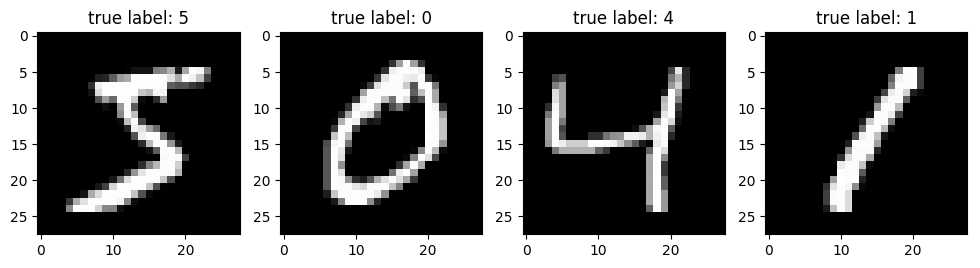

In [3]:
# visualize the 4 first mnist images before shuffling the pixels
plt.figure(figsize=(12,12))
for i in range(0,4):
    plt.subplot(1,4,(i+1))
    plt.imshow((X_train[i,:,:,0]),cmap="gray")
    plt.title('true label: '+np.str(np.argmax(Y_train,axis=1)[i]))
    #plt.axis('off')

In the next cell we shuffle the pixel of each image randomly around. Note that we shuffle every image in same manner!

In [0]:
# function to shuffle the pixel order within an image
# used to shuffel the pixels of all mnist images in the same manner
def shuffel_pixels(idx, data):
  data_new=np.zeros((data.shape))
  for i,img in enumerate(data):
    data_new[i] = img.flatten()[idx].reshape((28,28,1))
  return data_new

np.random.seed(42)
shuffel_idx = np.random.permutation(np.arange(28*28))
X_train_shuffle = shuffel_pixels(shuffel_idx, X_train)
X_val_shuffle = shuffel_pixels(shuffel_idx, X_val)
X_test_shuffle = shuffel_pixels(shuffel_idx, X_test)

Lets visualize the first 4 mnist images after shuffling the pixels randomly around. Now as a human you have no chance to recognise the true label of the digits.

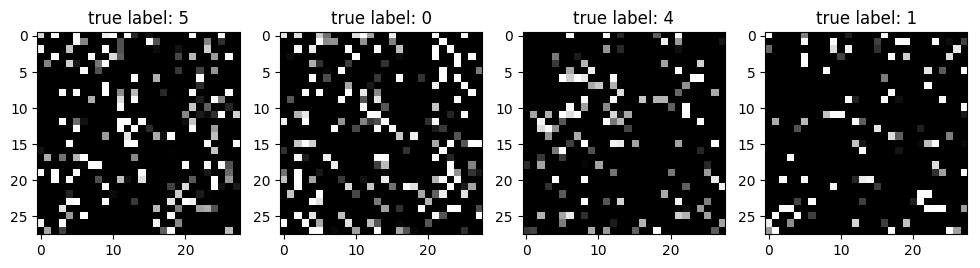

In [5]:
# visualize the 4 first mnist images after shuffling the pixels
plt.figure(figsize=(12,12))
for i in range(0,4):
    plt.subplot(1,4,(i+1))
    plt.imshow((X_train_shuffle[i,:,:,0]),cmap="gray")
    plt.title('true label: '+np.str(np.argmax(Y_train,axis=1)[i]))

## fcNN as classification model for MNIST data
Now we want to train a fcNN to classify the MNIST data. We use the same netwok architecture and train first with the original data and then with the shuffled data. 
* Use a fcNN with 2 hidden layers as classification model.
* train it once on the original train data and check the performance on the original test data
* train it once on the shuffeled train data and check the performance on the accordingly shuffled test data

Because we will use fcNN we need to flatten our inuput into a 1d vector. We do this in the next cell with reshape.

In [0]:
# prepare data for fcNN - we need a vector as input

# first do it for original data
X_train_flat = X_train.reshape([X_train.shape[0], 784])
X_val_flat = X_val.reshape([X_val.shape[0], 784])
X_test_flat = X_test.reshape([X_test.shape[0], 784])

# then do it for the shuffled data
X_train_shuffle_flat = X_train_shuffle.reshape([X_train_shuffle.shape[0], 784])
X_val_shuffle_flat = X_val_shuffle.reshape([X_val_shuffle.shape[0], 784])
X_test_shuffle_flat = X_test_shuffle.reshape([X_test_shuffle.shape[0], 784])


### Train the fcNN on the original data

In [7]:
# check the shape
X_train_flat.shape,Y_train.shape,X_val_flat.shape,Y_val.shape

((50000, 784), (50000, 10), (10000, 784), (10000, 10))

Here we define the nework, we use two hidden layers with 100 and 50 nodes. In the output we predict the probability for the 10 digits with the softmax actication function, in the hidden layers we use the sigmoid activation function. 

In [0]:
# define fcNN with 2 hidden layers
model = Sequential()

model.add(Dense(100, batch_input_shape=(None, 784)))
model.add(Activation('sigmoid'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [9]:
# summarize model along with number of model weights
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
activation_2 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


In [10]:
# train the model
history=model.fit(X_train_flat, Y_train, 
                  batch_size=128, 
                  epochs=10,
                  verbose=2, 
                  validation_data=(X_val_flat, Y_val)
                 )

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
 - 4s - loss: 0.9726 - acc: 0.7759 - val_loss: 0.3870 - val_acc: 0.9114
Epoch 2/10
 - 2s - loss: 0.3288 - acc: 0.9134 - val_loss: 0.2464 - val_acc: 0.9332
Epoch 3/10
 - 2s - loss: 0.2390 - acc: 0.9323 - val_loss: 0.1984 - val_acc: 0.9440
Epoch 4/10
 - 2s - loss: 0.1934 - acc: 0.9441 - val_loss: 0.1671 - val_acc: 0.9542
Epoch 5/10
 - 2s - loss: 0.1622 - acc: 0.9535 - val_loss: 0.1483 - val_acc: 0.9574
Epoch 6/10
 - 2s - loss: 0.1385 - acc: 0.9604 - val_loss: 0.1346 - val_acc: 0.9621
Epoch 7/10
 - 2s - loss: 0.1196 - acc: 0.9657 - val_loss: 0.1228 - val_acc: 0.9644
Epoch 8/10
 - 2s - loss: 0.1049 - acc: 0.9695 - val_loss: 0.1124 - val_acc: 0.9658
Epoch 9/10
 - 2s - loss: 0.0917 - acc: 0.9746 - val_loss: 0.1084 - val_acc: 0.9685
Epoch 10/10
 - 2s - loss: 0.0808 - acc: 0.9770 - val_loss: 0.1028 - val_acc: 0.9683


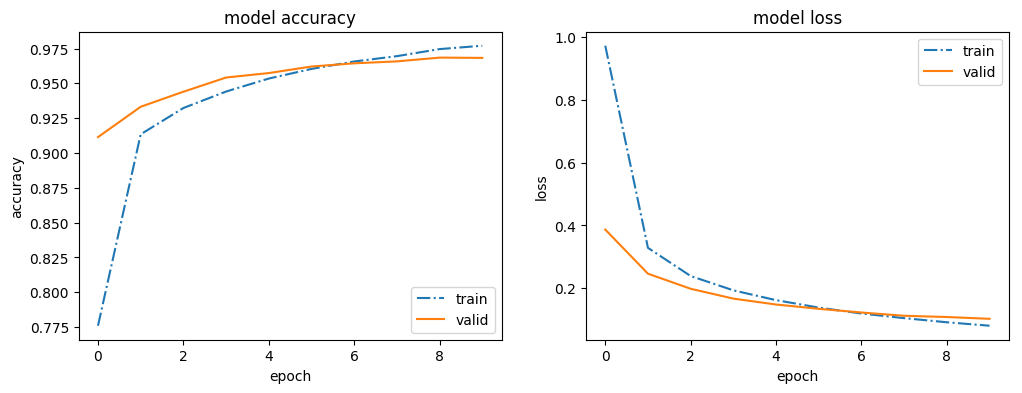

In [11]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['acc'],linestyle='-.')
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

#### Prediction on the original test set after training on original data

Now lets use the fcNN that was trained on the original data to predict new unseen data (our testdata).
We determine the confusion matrix and the accuracy on the testdata to evaluate the classification performance.


In [12]:
pred=model.predict(X_test_flat)
print(confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(pred,axis=1)))
acc_fc_orig = np.sum(np.argmax(Y_test,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Acc_fc_orig_flat = " , acc_fc_orig)

[[ 970    0    0    1    0    1    5    2    1    0]
 [   0 1120    4    0    0    1    4    2    4    0]
 [   7    1  992    1    3    1    7   10    7    3]
 [   0    0    5  964    0   17    0   11    8    5]
 [   2    0    2    0  954    0    8    5    2    9]
 [   3    1    0    4    2  869    8    0    3    2]
 [   5    2    0    0    3    8  937    0    3    0]
 [   1    4    8    3    1    1    0 1003    1    6]
 [   5    2    2    6    5    7    5    8  931    3]
 [   3    5    0    7   13    9    1   15    1  955]]
Acc_fc_orig_flat =  0.9695


### Train the fcNN on the shuffled data

In [13]:
# check the shape
X_train_shuffle_flat.shape,Y_train.shape,X_val_shuffle_flat.shape,Y_val.shape

((50000, 784), (50000, 10), (10000, 784), (10000, 10))

Here we define the nework, we use two hidden layers with 100 and 50 nodes. In the output we predict the probability for the 10 digits with the softmax actication function, in the hidden layers we use the sigmoid activation function. 

In [0]:
# define fcNN with 2 hidden layers
model = Sequential()

model.add(Dense(100, batch_input_shape=(None, 784)))
model.add(Activation('sigmoid'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
# train the model
history=model.fit(X_train_shuffle_flat, Y_train, 
                  batch_size=128, 
                  epochs=10,
                  verbose=2, 
                  validation_data=(X_val_shuffle_flat, Y_val)
                 )

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
 - 2s - loss: 0.9682 - acc: 0.7844 - val_loss: 0.3911 - val_acc: 0.9074
Epoch 2/10
 - 2s - loss: 0.3341 - acc: 0.9134 - val_loss: 0.2534 - val_acc: 0.9279
Epoch 3/10
 - 2s - loss: 0.2435 - acc: 0.9316 - val_loss: 0.2034 - val_acc: 0.9417
Epoch 4/10
 - 2s - loss: 0.1959 - acc: 0.9442 - val_loss: 0.1723 - val_acc: 0.9532
Epoch 5/10
 - 2s - loss: 0.1645 - acc: 0.9530 - val_loss: 0.1557 - val_acc: 0.9563
Epoch 6/10
 - 2s - loss: 0.1407 - acc: 0.9592 - val_loss: 0.1367 - val_acc: 0.9618
Epoch 7/10
 - 2s - loss: 0.1219 - acc: 0.9654 - val_loss: 0.1276 - val_acc: 0.9637
Epoch 8/10
 - 2s - loss: 0.1063 - acc: 0.9695 - val_loss: 0.1199 - val_acc: 0.9661
Epoch 9/10
 - 2s - loss: 0.0937 - acc: 0.9735 - val_loss: 0.1101 - val_acc: 0.9671
Epoch 10/10
 - 2s - loss: 0.0824 - acc: 0.9773 - val_loss: 0.1062 - val_acc: 0.9684


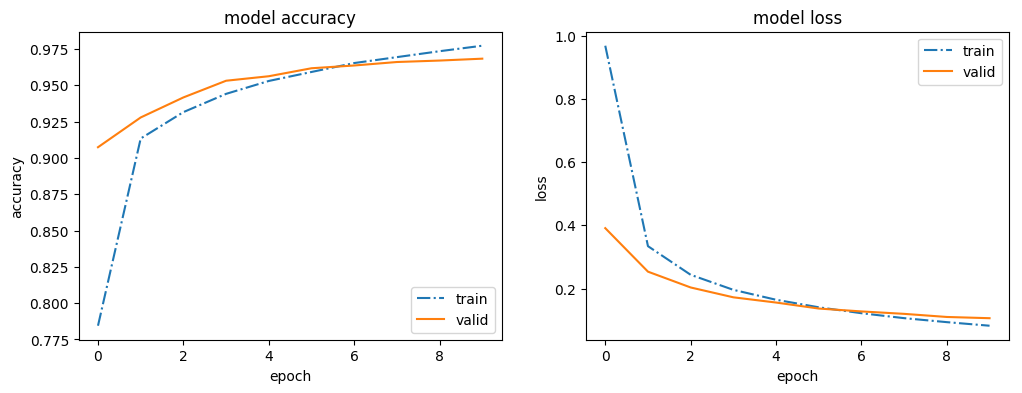

In [16]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['acc'],linestyle='-.')
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

#### Prediction on the shuffled test set after training on the shuffled data

Now lets use the fcNN that was trained on the shuffled data to predict new unseen data (our testdata).
We determine the confusion matrix and the accuracy on the testdata to evaluate the classification performance.



In [17]:
pred=model.predict(X_test_shuffle_flat)
print(confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(pred,axis=1)))
acc_fc_shuffled = np.sum(np.argmax(Y_test,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Acc_fc_shuffled_flat = " , acc_fc_shuffled)

[[ 971    0    0    1    0    3    2    1    1    1]
 [   0 1126    3    0    0    1    2    0    3    0]
 [   6    2  996    6    2    1    2    8    9    0]
 [   0    1    4  983    0    4    0    9    7    2]
 [   2    1    7    0  930    0    3    5    2   32]
 [   4    1    1   13    1  852    6    4    6    4]
 [   7    3    2    0    5    8  929    2    2    0]
 [   1    6   12    6    0    1    0  993    0    9]
 [   4    2    4   16    2    4    2    6  929    5]
 [   2    5    1   11   10    3    1   10    1  965]]
Acc_fc_shuffled_flat =  0.9674


**Note that in a fcNN the order of the data does not matter! The performace is the same if we use the original data for training and testing or if we use the shuffled data for the training and testing. In both cases the accuracy is around 96%.** 

#### Return to the book 
<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/Page_turn_icon_A.png" width="120" align="left" />  
Return to the book to learn about CNNs.

# CNN as classification model for MNIST data

Note: **Please only go on, after you read the CNN part in the book.**

Now lets do the same game with a CNN. We train a CNN to classify the MNIST data. We use the same netwok architecture and train first with the original data and then with the shuffled data. 
* Use a CNN with 2 convolution blocks and 2 fully connected layers as classification model
* train it once on the original train data and check the performance on the original test data
* train it once on the shuffeled train data and check the performance on the accordingly shuffled test data

### Train the CNN on the original data

In [18]:
# check the shape of the orginal data
# we need matrices as input
X_train.shape,Y_train.shape,X_val.shape,Y_val.shape

((50000, 28, 28, 1), (50000, 10), (10000, 28, 28, 1), (10000, 10))

In the next cell we define the hyperparameters and architecture of the CNN. We use:
>the relu activation function  
>batchsize of 128  
>kernelsize of 3x3  
>poolingsize of 2x2   
>our inputs are the greyscaled MNIST images, so the shape is 28x28x1  
> we use 2 convolutional blocks with 8 filters and then a maxpooling layer followed by again 2 convolutional blocks with 16 filters and then a maxpooling  
> then we flatten the output and use a fully connected layer with 40 nodes and the output has 10 nodes with the softmax activation.

In [0]:
# here we define hyperparameter of the CNN
batch_size = 128
nb_classes = 10
img_rows, img_cols = 28, 28
kernel_size = (3, 3)
input_shape = (img_rows, img_cols, 1)
pool_size = (2, 2)

In [0]:
# define CNN with 2 convolution blocks and 2 fully connected layers
model = Sequential()

model.add(Convolution2D(8,kernel_size,padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(8, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Convolution2D(16, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(16,kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dense(40))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [21]:
# summarize model along with number of model weights
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
activation_7 (Activation)    (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
activation_8 (Activation)    (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
activation_9 (Activation)    (None, 14, 14, 16)        0         
__________

In [22]:
# train the model
history=model.fit(X_train, Y_train, 
                  batch_size=128, 
                  epochs=10,
                  verbose=2, 
                  validation_data=(X_val, Y_val)
                 )

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
 - 7s - loss: 0.3607 - acc: 0.8938 - val_loss: 0.1124 - val_acc: 0.9663
Epoch 2/10
 - 4s - loss: 0.0919 - acc: 0.9719 - val_loss: 0.0645 - val_acc: 0.9827
Epoch 3/10
 - 4s - loss: 0.0646 - acc: 0.9793 - val_loss: 0.0635 - val_acc: 0.9828
Epoch 4/10
 - 4s - loss: 0.0493 - acc: 0.9848 - val_loss: 0.0504 - val_acc: 0.9871
Epoch 5/10
 - 4s - loss: 0.0408 - acc: 0.9873 - val_loss: 0.0531 - val_acc: 0.9851
Epoch 6/10
 - 4s - loss: 0.0340 - acc: 0.9891 - val_loss: 0.0452 - val_acc: 0.9879
Epoch 7/10
 - 4s - loss: 0.0295 - acc: 0.9905 - val_loss: 0.0439 - val_acc: 0.9876
Epoch 8/10
 - 4s - loss: 0.0262 - acc: 0.9909 - val_loss: 0.0418 - val_acc: 0.9891
Epoch 9/10
 - 4s - loss: 0.0213 - acc: 0.9928 - val_loss: 0.0449 - val_acc: 0.9882
Epoch 10/10
 - 4s - loss: 0.0186 - acc: 0.9938 - val_loss: 0.0405 - val_acc: 0.9890


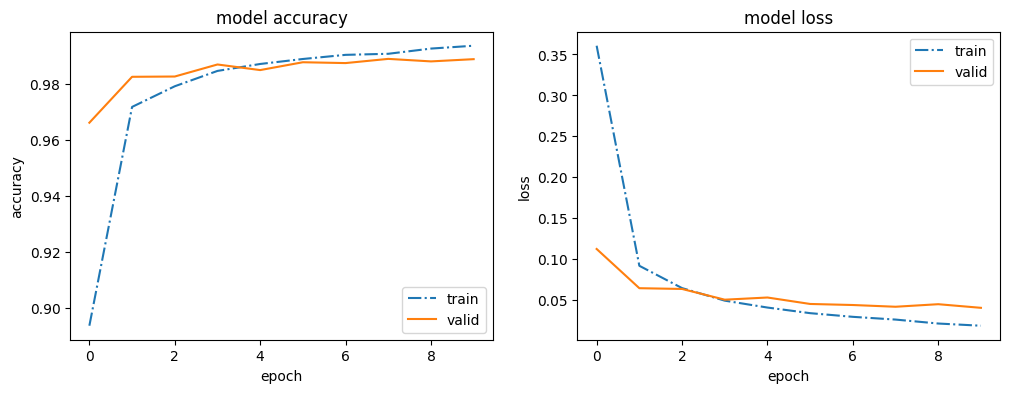

In [23]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['acc'],linestyle='-.')
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

#### Prediction on the test set after training on original data

Now lets use CNN that was trained on the original data to predict new unseen data (our testdata). We determine the confusion matrix and the accuracy on the testdata to evaluate the classification performance.

In [24]:
pred=model.predict(X_test)
print(confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(pred,axis=1)))
acc_fc_orig = np.sum(np.argmax(Y_test,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Acc_fc_orig = " , acc_fc_orig)

[[ 973    0    0    0    0    2    2    0    2    1]
 [   0 1133    0    0    0    2    0    0    0    0]
 [   2    4 1014    5    1    0    0    5    1    0]
 [   0    0    0 1002    0    3    0    2    1    2]
 [   0    0    2    0  975    0    1    0    0    4]
 [   2    0    0    6    0  881    3    0    0    0]
 [   1    2    2    0    1    1  950    0    1    0]
 [   0    4    6    0    0    0    0 1012    2    4]
 [   2    0    1    2    0    1    0    1  965    2]
 [   0    2    0    0    4    5    0    3    3  992]]
Acc_fc_orig =  0.9897


### Train the CNN on the shuffled data

In [25]:
# check the shape of the shuffled data
# we need matrices as input
X_train_shuffle.shape,Y_train.shape,X_val_shuffle.shape,Y_val.shape

((50000, 28, 28, 1), (50000, 10), (10000, 28, 28, 1), (10000, 10))

In [0]:
# define CNN with 2 convolution blocks and 2 fully connected layers  
model = Sequential()

model.add(Convolution2D(8,kernel_size,padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(8, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Convolution2D(16, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(16,kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dense(40))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [27]:
# train the model
history=model.fit(X_train_shuffle, Y_train, 
                  batch_size=128, 
                  epochs=10,
                  verbose=2, 
                  validation_data=(X_val_shuffle, Y_val)
                 )

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
 - 5s - loss: 0.7369 - acc: 0.7622 - val_loss: 0.3441 - val_acc: 0.8973
Epoch 2/10
 - 5s - loss: 0.3356 - acc: 0.8987 - val_loss: 0.2640 - val_acc: 0.9247
Epoch 3/10
 - 5s - loss: 0.2643 - acc: 0.9195 - val_loss: 0.2172 - val_acc: 0.9359
Epoch 4/10
 - 4s - loss: 0.2224 - acc: 0.9328 - val_loss: 0.2034 - val_acc: 0.9382
Epoch 5/10
 - 4s - loss: 0.1918 - acc: 0.9412 - val_loss: 0.1962 - val_acc: 0.9439
Epoch 6/10
 - 4s - loss: 0.1711 - acc: 0.9468 - val_loss: 0.1772 - val_acc: 0.9480
Epoch 7/10
 - 4s - loss: 0.1521 - acc: 0.9535 - val_loss: 0.1704 - val_acc: 0.9482
Epoch 8/10
 - 4s - loss: 0.1366 - acc: 0.9580 - val_loss: 0.1614 - val_acc: 0.9522
Epoch 9/10
 - 4s - loss: 0.1255 - acc: 0.9603 - val_loss: 0.1735 - val_acc: 0.9467
Epoch 10/10
 - 4s - loss: 0.1138 - acc: 0.9639 - val_loss: 0.1532 - val_acc: 0.9543


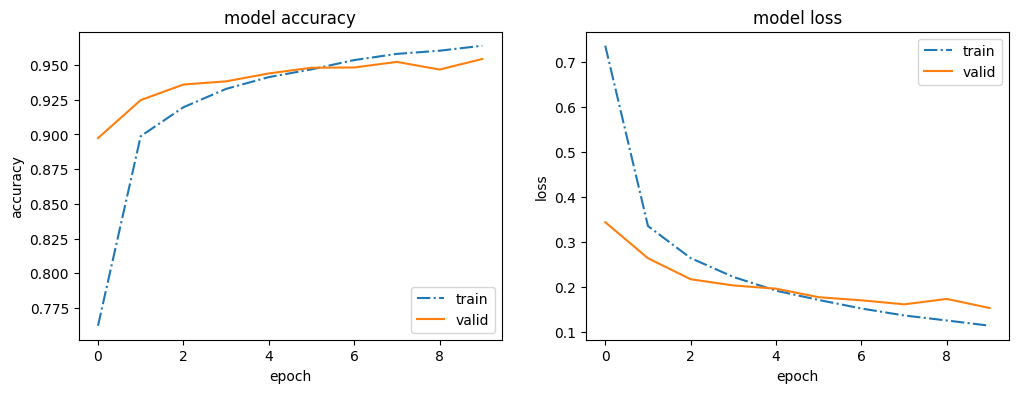

In [28]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['acc'],linestyle='-.')
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

#### Prediction on the test set after training on the shuffled data

Use the CNN that was trained on the shuffled data to predict new unseen data (our testdata). We determine the confusion matrix and the accuracy on the testdata to evaluate the classification performance.


In [29]:
pred=model.predict(X_test_shuffle)
print(confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(pred,axis=1)))
acc_fc_shuffled = np.sum(np.argmax(Y_test,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Acc_fc_shuffled = " , acc_fc_shuffled)

[[ 965    0    5    2    0    0    3    1    2    2]
 [   0 1118    4    1    0    1    4    1    6    0]
 [   8    2  977   15    1    1    2    8   15    3]
 [   1    1    1  982    0    9    0    5    8    3]
 [   4    1    9    0  903    1    9    6    6   43]
 [  11    2    2   26    0  828    9    1    9    4]
 [  15    3    3    0    2    7  922    3    3    0]
 [   4    4   13    5    2    0    0  970    3   27]
 [  10    0    6   21    3    8    7    4  903   12]
 [   5    2    4   10   10    5    0    9    6  958]]
Acc_fc_shuffled =  0.9526


# Conclusion

** In a CNN the order of the data does matter, the performace for the original images and for the shuffled are the different! The CNN performs better on the original data. The CNN trained on the original data achieved an accuracy of  99%, but the same CNN trained on the shuffled version of the data achieved only 95% accuracy.**

This was not the case when we used fcNN - here the performance did not change if the data was shuffled. The fcNN achieved an accuracy of 96% regardless if the data was shuffled or not.

## *It is worth to note that the CNN with "only" 35'962 model weights achieved a higher accuracy 99% than the fcNN with 84'060 model weights that achieved a smaller accuray 96%*


#### Play the deep learning game and ‘stack more layers and change the activation function from sigmoid to relu
<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  

*Exercise [optional]: Try to improve the fcNN by adding more hidden layers and/or changing the activation function from "sigmoid" to "relu". What do you observe. can you beat the performace of the CNN?*

